<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/dataset/notebooks/2.0-mb-data_preprocessing_loading_splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install wandb==0.13.4
!pip install scikit-learn==1.1.3
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution foun

In [39]:
import os
import random

from catboost import CatBoostClassifier

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
from numpy.testing import assert_almost_equal
from matplotlib import pyplot as plt
from pandas._testing.asserters import assert_almost_equal
import pandas as pd

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
import seaborn as sns

from tqdm.notebook import tqdm

import wandb


In [40]:
sns.set_theme(style="white")
plt.style.use("seaborn")

In [3]:
# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

dataset = wandb.Artifact(name="train_val_test", type="preprocessed_data")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [5]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)


seed = 42
seed_everything(seed)


In [ ]:
files = fs.glob(
    "thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_min_mem_usage_part_*.parquet",
    recursive=True,
)
files = [fs_prefix + sub for sub in files]

columns = [
    "UNDERLYING_SYMBOL",
    "QUOTE_DATETIME",
    "SEQUENCE_NUMBER",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "order_id",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "optionid",
    "day_vol",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]

dfs = []
for gc_file in tqdm(files):
    df = pd.read_parquet(gc_file, columns=columns)
    dfs.append(df)
df = pd.concat(dfs)


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
df.memory_usage(deep=True).sum()


10742886851

In [ ]:
df.head().T


,0,1,2,3,4
UNDERLYING_SYMBOL,BRCD,SYMC,SPY,ADRX,ORCL
QUOTE_DATETIME,2005-05-02 09:30:02,2005-05-02 09:30:03,2005-05-02 09:30:03,2005-05-02 09:30:03,2005-05-02 09:30:03
SEQUENCE_NUMBER,72515,65366,65373,79195,95870
ROOT,YNU,SYQ,SWG,QAX,ORQ
EXPIRATION,2006-01-21 00:00:00,2005-06-18 00:00:00,2005-05-21 00:00:00,2005-06-18 00:00:00,2005-12-17 00:00:00
STRK_PRC,2.5,15.0,105.0,25.0,14.0
OPTION_TYPE,C,C,C,C,C
TRADE_SIZE,10,10,50,10,15
TRADE_PRICE,2.05,3.9,11.2,0.2,0.25
BEST_BID,1.9,3.6,11.1,0.0,0.3


In [ ]:
# check against some stats from sub panel A.1 in Grauer et al

# trade size
stats_trade_size = df["TRADE_SIZE"].agg(["mean", "median", "std"])

assert_almost_equal(stats_trade_size.values.tolist(), [13.62, 4.0, 77.75], atol=0.1)

# moneyness; price underlying / strike
# TODO: Request price for underlyings?

# time to maturity
stats_time_to_maturity = (df["EXPIRATION"] - df["QUOTE_DATETIME"]).dt.days
stats_time_to_maturity = stats_time_to_maturity.agg(["mean", "median", "std"])

# no of observations
stats_n = len(df)
assert stats_n == 49203747

# trade_size = quote size; TRADE_SIZE
stats_trades_with_quote_size_bid = df["bid_size_ex"].eq(df["TRADE_SIZE"])
stats_trades_with_quote_size_ask = df["ask_size_ex"].eq(df["TRADE_SIZE"])

# either ask or bid must be equal, but not both (XOR)
# TODO: mismatch Grauer et. al report 22.28 % -> 0.10956509064238543
stats_trade_with_quote_size = (
    stats_trades_with_quote_size_bid ^ stats_trades_with_quote_size_ask
).sum() / stats_n

# no of buys
stats_buy_trades = df["buy_sell"].ge(0).sum() / stats_n
assert_almost_equal(stats_buy_trades, 0.4746, atol=0.01)

# underlyings per day
# stats_underlyings_per_day = df.groupby(['UNDERLYING_SYMBOL','QUOTE_DATETIME']).count().agg(['mean','median','std'])


## create subsample 🔢

In [ ]:
%%script false --no-raise-error

year = 2017 

output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_{year}.parquet"
df_sub = df[df['QUOTE_DATETIME'].dt.year == year]
df_sub.to_parquet(output_path)

dataset.add_reference(output_path, name=f'data_preprocessed_{year}')

[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_2017.parquet/data_preprocessed_2017>]

In [ ]:
%%script false --no-raise-error

year = 2015

output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_{year}.parquet"
df_sub = df[df['QUOTE_DATETIME'].dt.year == year]
df_sub.to_parquet(output_path)

dataset.add_reference(output_path, name=f'data_preprocessed_{year}')

[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_2015.parquet/data_preprocessed_2015>]

## train-test-split ⚗️

In [ ]:
%%script false --no-raise-error

train = df[df.QUOTE_DATETIME.between("2005-05-02 00:00:01", "2013-10-24 23:59:00")]

len_train = len(train) 
print(f"train ratio: {len_train / len(df)}")

train ratio: 0.5997575753732739


In [ ]:
%%script false --no-raise-error

val = df[df.QUOTE_DATETIME.between("2013-10-25 00:00:01", "2015-11-05 23:59:00")]
len_val = len(val) 
print(f"train ratio: {len_val / len(df)}")

train ratio: 0.1998191519845023


In [ ]:
%%script false --no-raise-error

test = df[df.QUOTE_DATETIME.between("2015-11-06 00:00:01", "2017-05-31 23:59:00")]
len_test = len(test) 
print(f"train ratio: {len_test / len(df)}")

train ratio: 0.20042327264222376


In [ ]:
%%script false --no-raise-error

# check if total is sum of its parts
assert len_train + len_val + len_test == len(df)

In [ ]:
%%script false --no-raise-error

train

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
0,BRCD,2005-05-02 09:30:02,72515,YNU,2006-01-21,2.5,C,10,2.05,1.90,...,1.90,131.0,20.0,1.90,1.90,21060388.0,10.0,1.90,2.10,1
1,SYMC,2005-05-02 09:30:03,65366,SYQ,2005-06-18,15.0,C,10,3.90,3.60,...,NaN,NaN,NaN,4.00,4.00,31624184.0,10.0,4.60,4.00,1
2,SPY,2005-05-02 09:30:03,65373,SWG,2005-05-21,105.0,C,50,11.20,11.10,...,11.10,300.0,300.0,11.80,11.00,31620976.0,50.0,11.90,11.00,-1
3,ADRX,2005-05-02 09:30:03,79195,QAX,2005-06-18,25.0,C,10,0.20,0.00,...,0.00,0.0,86.0,0.15,0.15,31560072.0,10.0,0.15,0.15,1
4,ORCL,2005-05-02 09:30:03,95870,ORQ,2005-12-17,14.0,C,15,0.25,0.30,...,0.25,3356.0,399.0,0.35,0.35,25240212.0,17.0,0.35,0.35,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510315,IWM,2013-10-24 16:13:41,2761533800,IWM,2013-11-08,106.0,P,43,0.15,0.15,...,0.15,43.0,26.0,0.16,0.16,101818080.0,1197.0,0.16,0.16,-1
29510316,XLE,2013-10-24 16:13:52,1900753200,XLE,2014-01-18,77.0,P,1,0.60,0.56,...,0.56,10.0,20.0,0.42,0.72,100555800.0,1.0,0.47,0.72,1
29510317,XLE,2013-10-24 16:13:52,1900753201,XLE,2014-01-18,71.0,P,1,0.23,0.21,...,0.21,340.0,528.0,0.19,0.30,80840608.0,1.0,0.20,0.30,-1
29510318,IWM,2013-10-24 16:14:33,2764251401,IWM,2013-11-08,106.0,P,31,0.16,0.16,...,0.16,31.0,21.0,0.15,0.15,101818080.0,1197.0,0.15,0.15,-1


In [ ]:
%%script false --no-raise-error

val

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
29510320,IWM,2013-10-25 09:30:00,1901202,IWM,2014-03-31,97.0,P,20,1.47,1.38,...,NaN,NaN,NaN,1.60,1.62,100723144.0,20.0,1.12,2.73,-1
29510321,IWM,2013-10-25 09:30:00,1901203,IWM,2014-09-30,105.0,P,20,6.27,5.85,...,5.85,115.0,11.0,6.32,7.69,101786576.0,20.0,5.92,10.29,1
29510322,UNG,2013-10-25 09:30:00,2497905,UNG,2013-12-21,18.0,C,2,1.32,1.19,...,1.19,82.0,82.0,1.30,1.25,101943840.0,2.0,1.02,1.19,1
29510323,VXX,2013-10-25 09:30:00,2693702,VXX,2013-10-25,14.5,P,20,1.66,1.62,...,1.62,99.0,172.0,1.62,1.60,101658624.0,82.0,1.62,1.60,1
29510324,GRPN,2013-10-25 09:30:00,2310303,GRPN,2013-10-25,10.5,P,1,0.85,0.00,...,NaN,NaN,NaN,0.50,0.86,101849752.0,4.0,0.65,0.86,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39342166,UVXY,2015-11-05 16:14:37,50723741,UVXY,2015-11-06,27.0,C,1,0.88,0.86,...,0.86,12.0,21.0,0.70,0.90,109295920.0,4.0,0.46,1.88,-1
39342167,QQQ,2015-11-05 16:14:40,114141336,QQQ,2015-12-18,109.0,C,2,6.59,6.51,...,6.51,1078.0,1077.0,6.58,6.42,105521016.0,18.0,6.64,6.42,-1
39342168,SPY,2015-11-05 16:14:53,31158048,SPY,2015-12-24,220.0,P,1,11.42,11.08,...,11.08,10.0,10.0,12.63,NaN,109720304.0,2.0,11.41,11.41,1
39342169,SPY,2015-11-05 16:14:53,98266912,SPY,2015-12-24,220.0,P,1,11.41,11.08,...,11.08,10.0,10.0,11.42,11.42,109720304.0,2.0,12.63,NaN,1


In [ ]:
%%script false --no-raise-error

test

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
39342171,EWZ,2015-11-06 09:30:00,234098,EWZ,2015-12-18,22.0,P,2,0.520000,0.520000,...,0.520000,31.0,11.0,0.57,0.460000,107453656.0,3.0,0.59,0.45,-1
39342172,TSLA,2015-11-06 09:30:00,134917,TSLA,2015-11-27,230.0,C,1,7.820000,7.600000,...,7.600000,1.0,1.0,8.16,8.500000,109398624.0,1.0,4.97,8.37,-1
39342173,TSLA,2015-11-06 09:30:00,135092,TSLA,2017-01-20,260.0,C,1,28.889999,28.799999,...,28.799999,1.0,1.0,30.23,30.799999,105940216.0,3.0,29.90,29.00,-1
39342174,VB,2015-11-06 09:30:00,188332,VB,2015-11-20,115.0,C,1,2.250000,1.850000,...,1.850000,10.0,10.0,0.64,1.480000,109232832.0,1.0,NaN,NaN,1
39342175,VB,2015-11-06 09:30:00,188332,VB,2015-12-18,117.0,C,1,1.700000,1.700000,...,1.700000,10.0,10.0,0.65,2.200000,107538000.0,1.0,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49203742,SVXY,2017-05-31 16:12:19,225274471,SVXY,2017-06-02,152.0,C,1,3.540000,2.720000,...,2.720000,20.0,10.0,4.75,3.000000,115528016.0,1.0,5.24,3.85,-1
49203743,SPY,2017-05-31 16:12:45,190004593,SPY,2017-12-15,236.0,P,6,7.270000,7.220000,...,7.190000,753.0,1250.0,7.20,7.610000,113308776.0,6.0,5.37,9.01,1
49203744,^NDX,2017-05-31 16:13:39,35914334,NDX,2017-06-02,5690.0,P,12,1.000000,0.400000,...,0.000000,0.0,13.0,0.47,1.400000,115919712.0,83.0,0.47,1.40,-1
49203745,DIA,2017-05-31 16:14:02,72897705,DIA,2017-06-02,212.0,C,2,0.050000,0.030000,...,0.000000,0.0,22.0,0.03,0.010000,115563008.0,2.0,0.06,0.14,1


In [ ]:
%%script false --no-raise-error

output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet"
train.to_parquet(output_path)
dataset.add_reference(output_path,name='train_set_60')

[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet/train_set_60>]

In [ ]:
%%script false --no-raise-error

output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet"
val.to_parquet(output_path)
dataset.add_reference(output_path,name='val_set_20')

[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet/val_set_20>]

In [ ]:
%%script false --no-raise-error

output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet"
test.to_parquet(output_path)
dataset.add_reference(output_path,name='test_set_20')

[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet/test_set_20>]

In [ ]:
%%script false --no-raise-error

# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

wandb.finish()

## Adversarial Validation
> Adversarial Validation is a technique allowing you to easily estimate the degree of difference between your training and test data. This technique was long rumored among Kaggle participants and transmitted from team to team until it emerged publicly thanks to a post by Zygmunt Zając (https://www.kaggle.com/zygmunt) on his FastML blog. (adapted from Banchawicz et. al)

In [ ]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet"
)
test = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet"
)


In [ ]:
# randomly sample 10 % of rows
train = train.sample(frac=0.1, random_state=seed)
test = test.sample(frac=0.1, random_state=seed)


In [ ]:
train.head().T


,3249281,11026460,11754654,12792033,27061954
UNDERLYING_SYMBOL,BRCD,FWLT,SOHU,AKS,GG
QUOTE_DATETIME,2006-09-06 15:15:23,2009-01-30 14:21:48,2009-04-06 13:43:46,2009-07-07 09:46:26,2013-04-09 11:29:28
SEQUENCE_NUMBER,45901325,5958500,65221901,14278450,86483497
ROOT,YNU,UFB,UZK,ASJ,GG
EXPIRATION,2008-01-19 00:00:00,2009-05-16 00:00:00,2009-04-18 00:00:00,2009-09-19 00:00:00,2013-04-20 00:00:00
STRK_PRC,5.0,22.5,55.0,16.0,36.0
OPTION_TYPE,C,P,C,C,P
TRADE_SIZE,5,5,1,1,1
TRADE_PRICE,2.05,5.3,0.2,3.0,3.71
BEST_BID,1.95,5.2,0.1,2.95,3.65


In [ ]:
train["time_to_maturity"] = (train["EXPIRATION"] - train["QUOTE_DATETIME"]).dt.days
test["time_to_maturity"] = (test["EXPIRATION"] - test["QUOTE_DATETIME"]).dt.days

train = train.drop(["buy_sell", "QUOTE_DATETIME", "EXPIRATION"], axis=1)
test = test.drop(["buy_sell", "QUOTE_DATETIME", "EXPIRATION"], axis=1)
X = train.append(test)

# assign zeros to train set and ones to test set
y = [0] * len(train) + [1] * len(test)


In [ ]:
print(X.dtypes)


UNDERLYING_SYMBOL      object
SEQUENCE_NUMBER         int64
ROOT                   object
STRK_PRC              float32
OPTION_TYPE          category
TRADE_SIZE              int64
TRADE_PRICE           float32
BEST_BID              float32
BEST_ASK              float32
order_id                int64
ask_ex                float32
bid_ex                float32
bid_size_ex           float32
ask_size_ex           float32
price_all_lead        float32
price_all_lag         float32
optionid              float32
day_vol               float32
price_ex_lead         float32
price_ex_lag          float32
time_to_maturity        int64
dtype: object


### Metrics

In [ ]:
# perform cv with catboost classifier
model = CatBoostClassifier(
    max_depth=8,
    task_type="GPU",
    cat_features=["OPTION_TYPE", "UNDERLYING_SYMBOL", "ROOT"],
    logging_level="Silent",
)
cv_preds = cross_val_predict(model, X, y, cv=5, method="predict_proba")


In [ ]:
# train and test set are easily distinguishable
print(roc_auc_score(y_true=y, y_score=cv_preds[:, 1]))


0.9999999062158896


In [ ]:
model.fit(X, y)

ranks = sorted(
    list(zip(X.columns, model.feature_importances_)), key=lambda x: x[1], reverse=True
)
for feature, score in ranks:
    print(f"{feature:10} : {score:0.4f}")


order_id   : 35.7731
optionid   : 12.9560
ROOT       : 10.5818
UNDERLYING_SYMBOL : 7.9693
STRK_PRC   : 7.4104
ask_size_ex : 5.0776
SEQUENCE_NUMBER : 4.3934
bid_size_ex : 4.0263
time_to_maturity : 2.3588
day_vol    : 1.4306
TRADE_PRICE : 1.4053
price_ex_lead : 1.0435
TRADE_SIZE : 1.0414
price_all_lead : 0.8083
price_all_lag : 0.7548
BEST_ASK   : 0.5877
bid_ex     : 0.5222
OPTION_TYPE : 0.5182
BEST_BID   : 0.4969
ask_ex     : 0.4764
price_ex_lag : 0.3680


In [ ]:
# remove problematic features
X = X.drop(
    [
        "SEQUENCE_NUMBER",
        "UNDERLYING_SYMBOL",
        "ROOT",
        "order_id",
        "optionid",
        "time_to_maturity",
    ],
    axis=1,
)


In [ ]:
# perform cv with catboost classifier
model = CatBoostClassifier(
    max_depth=8, task_type="GPU", cat_features=["OPTION_TYPE"], logging_level="Silent"
)
cv_preds = cross_val_predict(model, X, y, cv=5, method="predict_proba")


In [ ]:
# Train and test set is still easily distinguishable
print(roc_auc_score(y_true=y, y_score=cv_preds[:, 1]))


0.8555422095743426


In [ ]:
# approximate feature importances
model.fit(X, y)

ranks = sorted(
    list(zip(X.columns, model.feature_importances_)), key=lambda x: x[1], reverse=True
)
for feature, score in ranks:
    print(f"{feature:10} : {score:0.4f}")


STRK_PRC   : 27.1455
bid_size_ex : 15.9818
ask_size_ex : 15.2004
ask_ex     : 11.5093
bid_ex     : 10.0615
price_ex_lead : 3.9084
price_ex_lag : 3.2172
TRADE_PRICE : 3.0070
TRADE_SIZE : 2.3206
day_vol    : 1.6695
BEST_BID   : 1.6158
BEST_ASK   : 1.2027
price_all_lag : 1.1064
OPTION_TYPE : 1.0659
price_all_lead : 0.9880


**Observations:**

`ROOT` and `UNDERLYING_SYMBOL` play a major role in the ability to differentiate between train and test set. This is logical as certain underlyings e.g., Tesla have hardly been traded in the training set and are thus only present in the test set. Can be resolved by removing it.

Dates like `EXPIRATION` also makes the data sets easily distinguishable. Can be resolved by removing it and keeping only `time_to_maturity`.

### Visualization

In [8]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet"
)
valid = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet"
)
test = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet"
)


In [9]:
# randomly sample 10 % of rows
train = train.sample(frac=0.1, random_state=seed)
valid = valid.sample(frac=0.1, random_state=seed)
test = test.sample(frac=0.1, random_state=seed)


In [10]:
train["time_to_maturity"] = (train["EXPIRATION"] - train["QUOTE_DATETIME"]).dt.days
valid["time_to_maturity"] = (valid["EXPIRATION"] - valid["QUOTE_DATETIME"]).dt.days
test["time_to_maturity"] = (test["EXPIRATION"] - test["QUOTE_DATETIME"]).dt.days

train = train.drop(["buy_sell", "QUOTE_DATETIME", "EXPIRATION"], axis=1)
valid = valid.drop(["buy_sell", "QUOTE_DATETIME", "EXPIRATION"], axis=1)
test = test.drop(["buy_sell", "QUOTE_DATETIME", "EXPIRATION"], axis=1)


In [108]:
def plot_hist(feature: str) -> None:
    """
    Plot combined histogram of features in train, validation, and test set.

    Args:
        feature (str): name of feature
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.hist([train[[feature]], valid[[feature]], test[[feature]]], 
        label=["train", "valid", "test"],
        stat="percent",
    )
    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_kde(feature: str) -> None:
    """
    Plot combined histogram of features in train, validation, and test set.

    Args:
        feature (str): name of feature
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(
        data=train[[feature]],
        label="train",
        color="dark fuchsia",
        fill=True,
        ax=ax,
    )
    sns.kdeplot(
        data=valid[[feature]],
        label="valid",
        fill=True,
        color='limegreen',
        ax=ax,
    )
    sns.kdeplot(
        data=test[[feature]],
        label="test",
        fill=True,
        color='marine',
        ax=ax,
    )
    ax.legend()
    plt.title(f"distribution of '{feature}' in train, validation, and test set")
    plt.tight_layout()
    plt.show()

In [65]:
n = 20
ser_train = train['ROOT'].value_counts()[:n]
ser_valid = valid['ROOT'].value_counts()[:n]
ser_test = test['ROOT'].value_counts()[:n]

n_symbols = pd.concat([ser_train, ser_valid, ser_test], axis=1)
n_symbols.columns = ["ROOT (train)","ROOT (val)", "ROOT (test)"]

n_symbols.head(n)

,ROOT (train),ROOT (val),ROOT (test)
SPY,30798.0,25301.0,39771.0
AAPL,20182.0,15487.0,12591.0
GLD,20119.0,7764.0,10298.0
IWM,14804.0,13073.0,14832.0
RUT,14111.0,NaN,NaN
QQQ,11438.0,7928.0,11244.0
DIA,11083.0,8529.0,8308.0
NDX,10283.0,13379.0,10276.0
GOOG,10273.0,7786.0,7652.0
GDX,9847.0,NaN,NaN


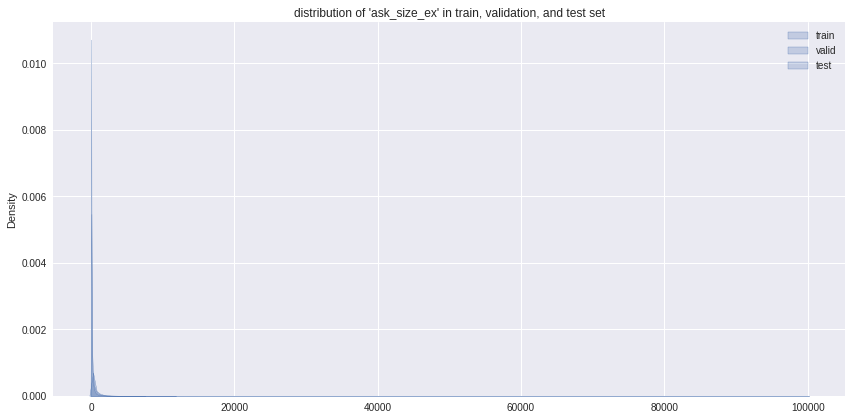

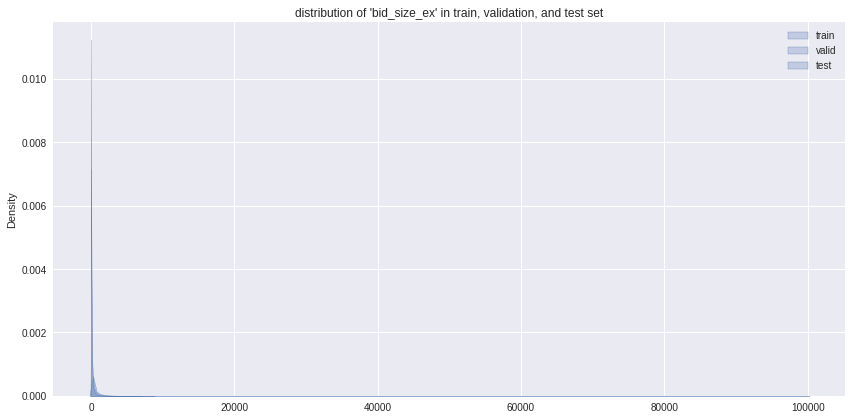

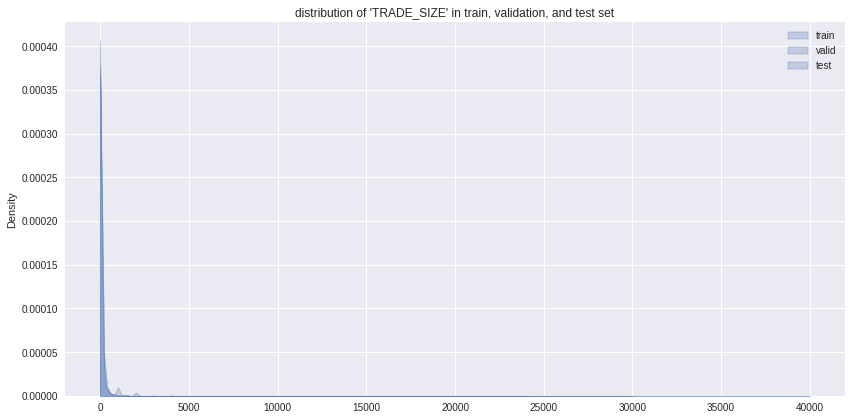

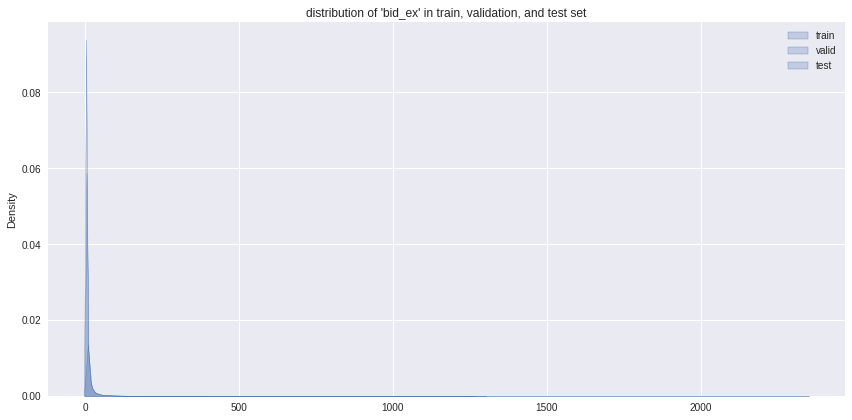

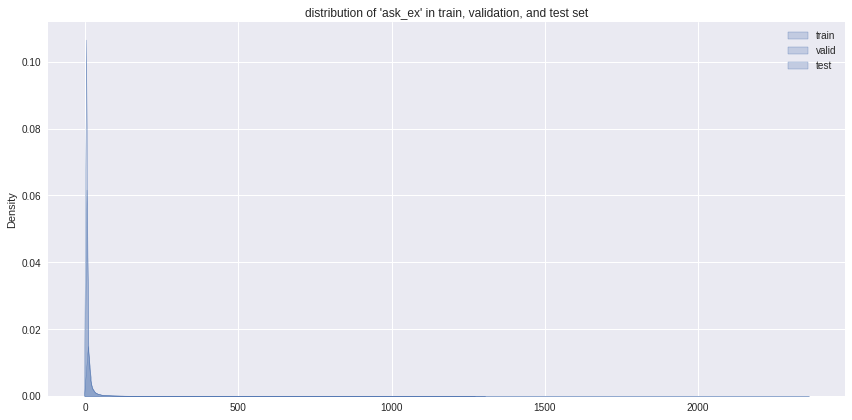

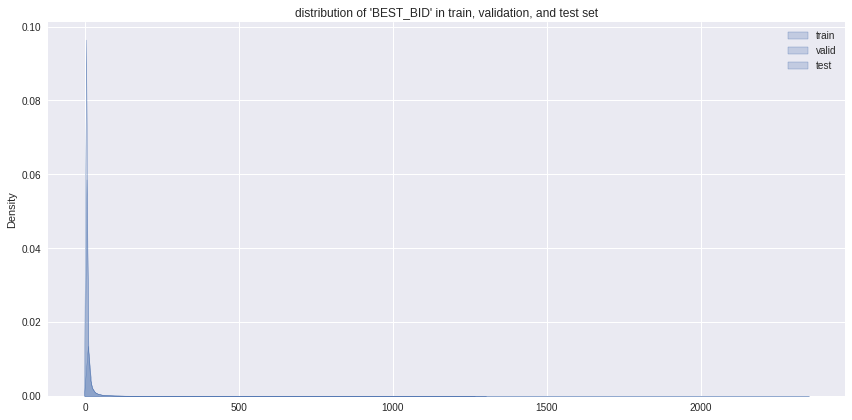

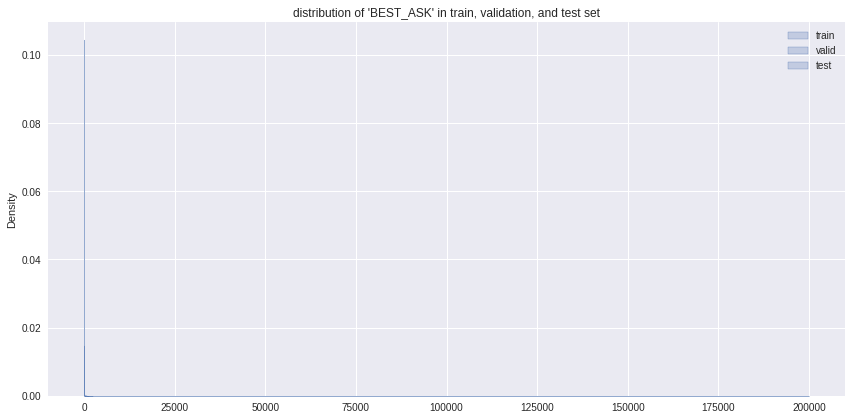

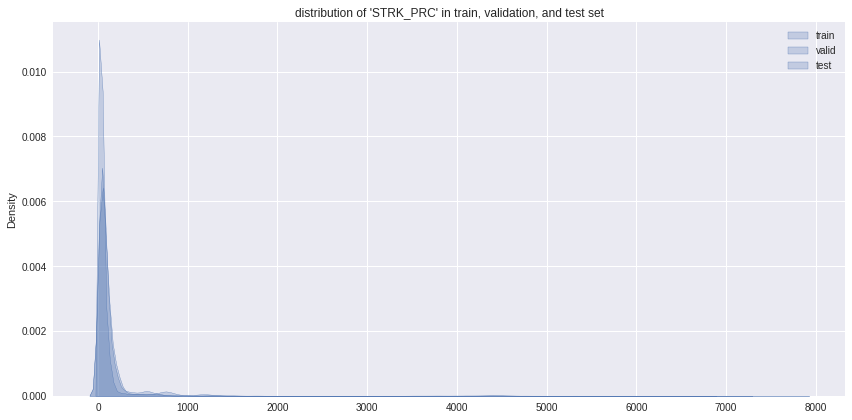

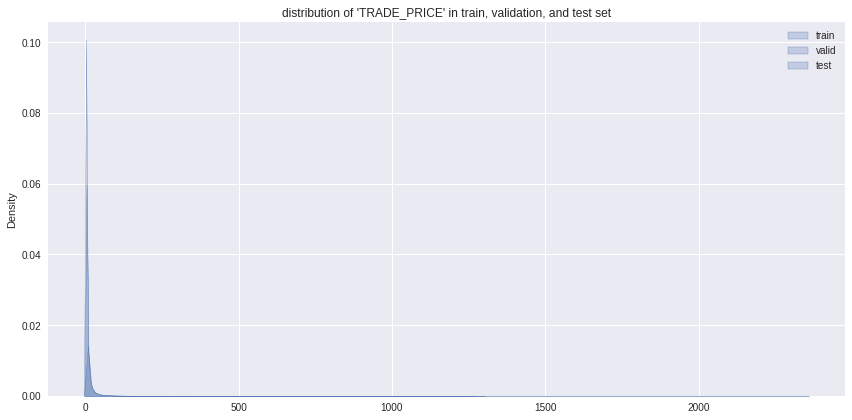

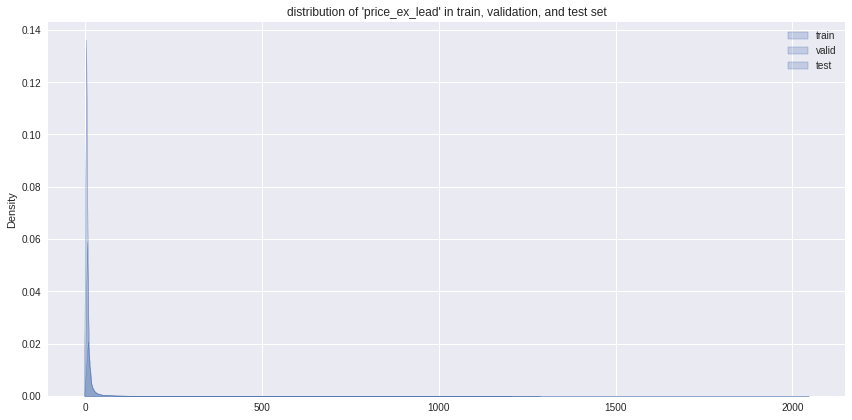

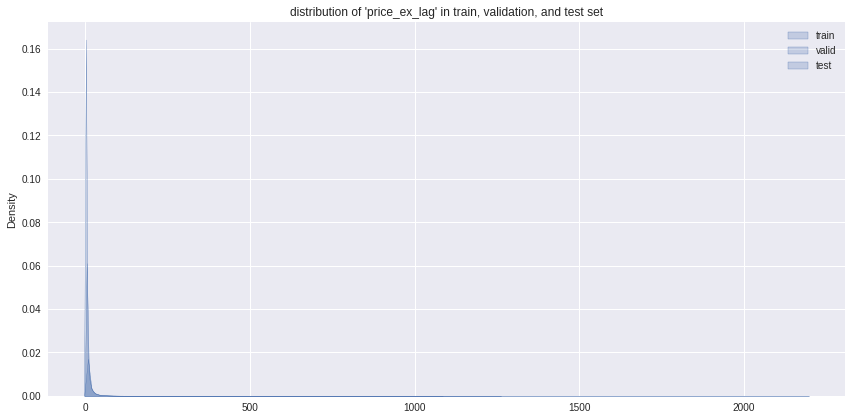

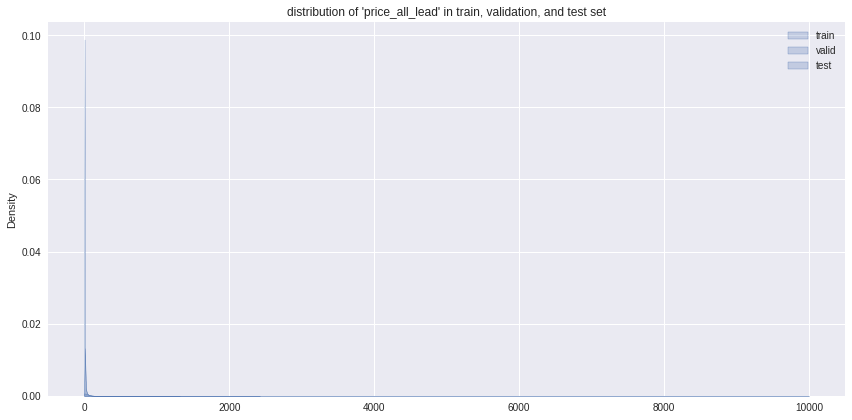

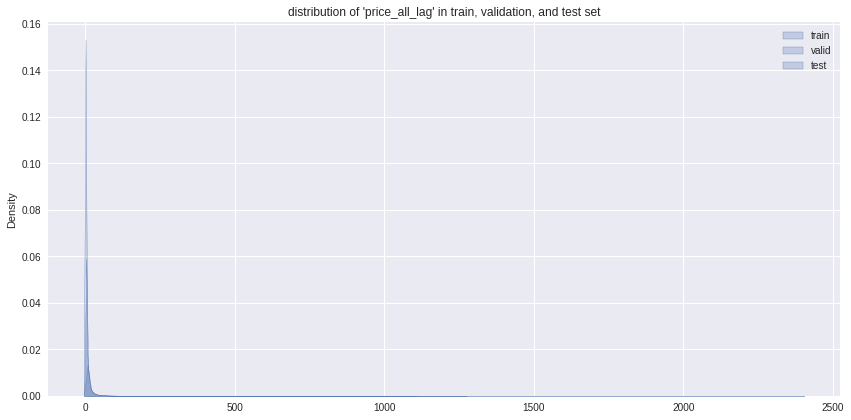

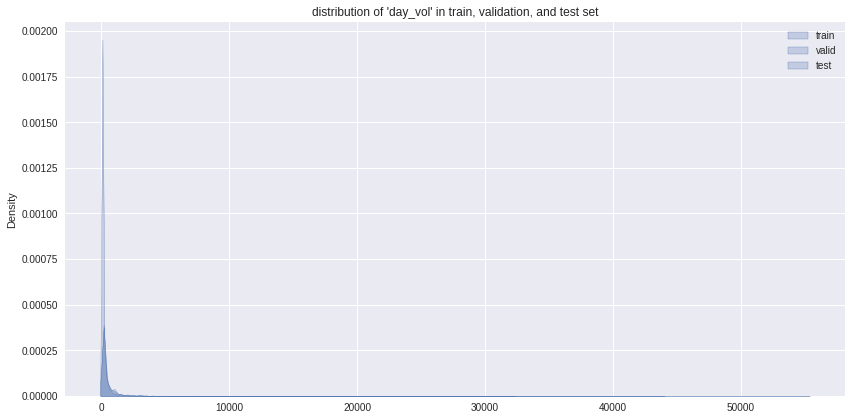

In [109]:
plot_kde("ask_size_ex")
plot_kde("bid_size_ex")
plot_kde("TRADE_SIZE")

plot_kde("bid_ex")
plot_kde("ask_ex")
plot_kde("BEST_BID")
plot_kde("BEST_ASK")

plot_kde("STRK_PRC")
plot_kde("TRADE_PRICE")

plot_kde("price_ex_lead")
plot_kde("price_ex_lag")
plot_kde("price_all_lead")
plot_kde("price_all_lag")

plot_kde("day_vol")